# Init

In [1]:
!pip install prophet pmdarima > /dev/null 2>&1

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.graphics.tsaplots import plot_acf

from IPython.display import display, HTML


In [3]:
def split_train_test(df, date_column="date", hist_end=pd.Timestamp("2015-12")):#, train_test_split = 0.8):
    
    #df = df.sort_values(date_column)
    #total_lines = len(df)
    #train_lines = int(np.floor(train_test_split * total_lines))
    #df_train = df.head(train_lines)
    #df_test = df.tail( total_lines - train_lines)

    df_train = df[df[date_column] <= hist_end]
    df_test = df[df[date_column] > hist_end]
    
    return df_train, df_test


# case 1 global temperatures

## fetch (open) data

In [4]:
!mkdir -p data
!wget -O data/data.csv https://datahub.io/core/global-temp/r/monthly.csv
#data comes from: https://datahub.io/core/global-temp

--2021-11-02 10:31:17--  https://datahub.io/core/global-temp/r/monthly.csv
Resolving datahub.io (datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/core/global-temp/monthly_csv/data/c1321100952fc1b643ec604ae65a104a/monthly_csv.csv [following]
--2021-11-02 10:31:19--  https://pkgstore.datahub.io/core/global-temp/monthly_csv/data/c1321100952fc1b643ec604ae65a104a/monthly_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3033::6815:28dd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82182 (80K) [text/csv]
Saving to: ‘data/data.csv’

data/data.csv       100%[===================>]  80.26K  --.-KB/s    in 0.01s   

2021-11-02 10:31:19 (6.92 MB/s) - ‘data/data.

In [5]:
df_temp = pd.read_csv("data/data.csv")
df_temp = (
    df_temp[df_temp["Source"] == "GISTEMP"]
    .drop(columns="Source")
    .rename(columns={
        "Mean": "temperature",
        "Date": "date",
    })
    .sort_values("date")
)
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["year"] = df_temp["date"].dt.year
df_temp["month"] = df_temp["date"].dt.month
df_temp["date"] = pd.to_datetime( df_temp["year"].astype(str) + "-" + df_temp["month"].astype(str) + "-01" )
df_temp["month_name"] = df_temp["date"].dt.strftime("%b") 
df_temp = df_temp[["date", "year", "month", "month_name", "temperature"]]
df_temp.head(3)

date  year  month month_name  temperature
3287 1880-01-01  1880      1        Jan        -0.30
3285 1880-02-01  1880      2        Feb        -0.21
3283 1880-03-01  1880      3        Mar        -0.18

## visualize

In [6]:
fig = px.line(
    df_temp,
    x="date",
    y="temperature",
    title='average temperature',
)
fig.show()


fig = px.line_polar(
    df_temp[df_temp["year"] > 2000],
    r="temperature",
    theta="month_name",
    color="year",
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    line_close=True,
    title='average temperature'
)
fig.show()

## split train test set

In [7]:
df_train, df_test = split_train_test(df_temp, date_column="date", hist_end=pd.Timestamp("2014-12"))

#print( len(df), len(df_train), len(df_test))
display( df_temp.agg({"date": ["min", "max", "count"]}) )
display( df_train.agg({"date": ["min", "max", "count"]}) )
display( df_test.agg({"date": ["min", "max", "count"]}) )

date
min    1880-01-01 00:00:00
max    2016-12-01 00:00:00
count                 1644

date
min    1880-01-01 00:00:00
max    2014-12-01 00:00:00
count                 1620

date
min    2015-01-01 00:00:00
max    2016-12-01 00:00:00
count                   24

## autocorrelation

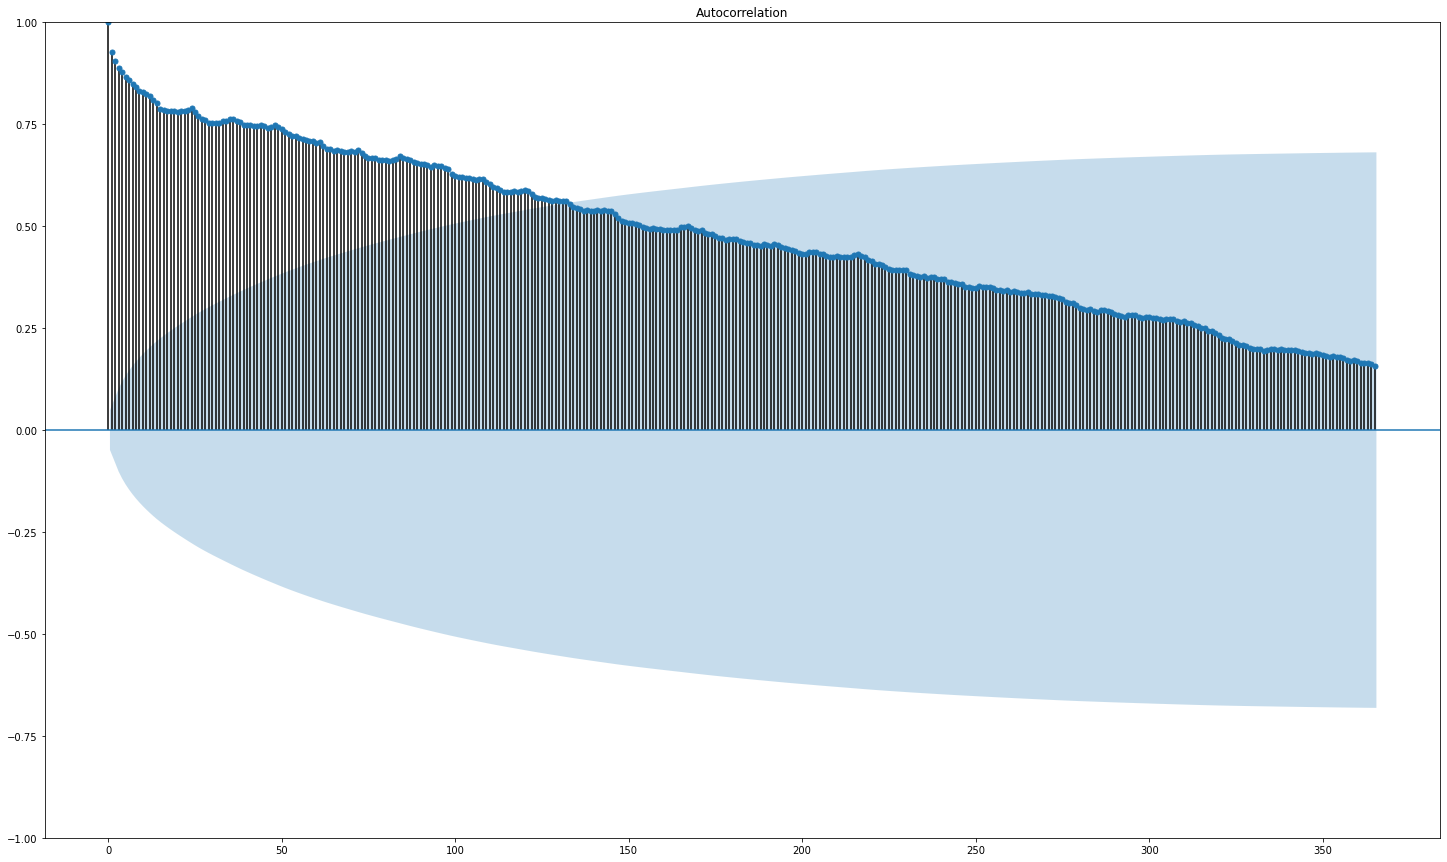

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(25,15))
plot_acf(df_train["temperature"], lags=365, ax=axs);

## forecast

In [9]:
m = Prophet()
df = df_train.rename(columns={"date": "ds", "temperature":"y"})
m.fit(df)

future = m.make_future_dataframe(periods=12, freq="MS")
forecast = m.predict(future)

# Python
fig = plot_plotly(m, forecast)
fig.show()

fig = plot_components_plotly(m, forecast)
fig.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## evaluate forecast

In [10]:
display(df_test.head(3))
display(forecast[["ds", "yhat"]].rename(columns={"ds": "date"}).tail(3))

df = pd.merge(
    df_test,
    forecast[["ds", "yhat"]].rename(columns={"ds": "date"}),
    left_on="date",
    right_on="date"
)
df['FC_E'] = df["yhat"] - df["temperature"]
df['FC_AE'] = np.abs(df['FC_E'])
df['FC_PE'] = df['FC_E'] / df["temperature"]
df['FC_APE'] = np.abs(df['FC_PE'])
display(df.head(3))

display(df[["FC_E", "FC_AE", "FC_PE", "FC_APE"]].agg(['mean', 'median', 'std']).T)

date  year  month month_name  temperature
47 2015-01-01  2015      1        Jan         0.81
45 2015-02-01  2015      2        Feb         0.86
43 2015-03-01  2015      3        Mar         0.90

date      yhat
1629 2015-10-01  0.773483
1630 2015-11-01  0.764656
1631 2015-12-01  0.714705

date  year  month month_name  ...      FC_E     FC_AE     FC_PE    FC_APE
0 2015-01-01  2015      1        Jan  ... -0.082447  0.082447 -0.101786  0.101786
1 2015-02-01  2015      2        Feb  ... -0.129265  0.129265 -0.150308  0.150308
2 2015-03-01  2015      3        Mar  ... -0.155384  0.155384 -0.172649  0.172649

[3 rows x 10 columns]

mean    median       std
FC_E   -0.123777 -0.069526  0.131173
FC_AE   0.130271  0.069526  0.124124
FC_PE  -0.126305 -0.087179  0.120656
FC_APE  0.135450  0.087179  0.109300

In [11]:
import plotly.figure_factory as ff
#nuttig ? weinig data om in dist te steken

fig = ff.create_distplot(
    [df["FC_E"], df["FC_PE"]],
    ["FC_E", "FC_PE"],
    bin_size=0.05
)
fig.show()

fig = ff.create_distplot(
    [df["FC_AE"], df["FC_APE"]],
    ["FC_AE", "FC_APE"],
    bin_size=0.01
)
fig.show()

# Fietstellingen

## fetch (open) data

In [12]:
#https://opendata.apps.mow.vlaanderen.be/fietstellingen/index.html
base_url = "https://opendata.apps.mow.vlaanderen.be/fietstellingen/"

os.system("mkdir -p data_gent/")
start = pd.Timestamp("2019-08")
stop = datetime.datetime.now()
paths = list()

month = start
while month < stop:

    fname = "data-" + month.strftime("%Y-%m") + ".csv"
    url = base_url + fname
    outname = "data_gent/" + fname
    os.system("wget -O " + outname + " " + url)
    paths.append(outname)

    print(fname)
    month += relativedelta(months=1)

df_cycle = pd.concat([
    pd.read_csv(
        path,
        sep=",",
        names=[
            "site",
            "direction",
            "type",
            "start_time",
            "stop_time",
            "count"
        ]
    )
    for path in paths
])

df_cycle = (
    df_cycle[df_cycle["type"] == "FIETSERS"]
    .rename(columns={"start_time": "date"})
)
df_cycle["date"] = pd.to_datetime(df_cycle["date"])
df_cycle["date"] = df_cycle["date"].dt.floor("h")
df_cycle = (
    df_cycle
    .groupby("date")
    .agg({"count": "sum"})
    .reset_index()
)
df_cycle["month_name"] = df_cycle["date"].dt.strftime("%b")
df_cycle["day_name"] = df_cycle["date"].dt.strftime("%A") 

display(df_cycle.head(10))
display(df_cycle.agg({"date": ["min", "max", "count"]}))

data-2019-08.csv
data-2019-09.csv
data-2019-10.csv
data-2019-11.csv
data-2019-12.csv
data-2020-01.csv
data-2020-02.csv
data-2020-03.csv
data-2020-04.csv
data-2020-05.csv
data-2020-06.csv
data-2020-07.csv
data-2020-08.csv
data-2020-09.csv
data-2020-10.csv
data-2020-11.csv
data-2020-12.csv
data-2021-01.csv
data-2021-02.csv
data-2021-03.csv
data-2021-04.csv
data-2021-05.csv
data-2021-06.csv
data-2021-07.csv
data-2021-08.csv
data-2021-09.csv
data-2021-10.csv
data-2021-11.csv


date  count month_name  day_name
0 2019-08-01 00:00:00   51.0        Aug  Thursday
1 2019-08-01 01:00:00   25.0        Aug  Thursday
2 2019-08-01 02:00:00   26.0        Aug  Thursday
3 2019-08-01 03:00:00   19.0        Aug  Thursday
4 2019-08-01 04:00:00   38.0        Aug  Thursday
5 2019-08-01 05:00:00   96.0        Aug  Thursday
6 2019-08-01 06:00:00  311.0        Aug  Thursday
7 2019-08-01 07:00:00  627.0        Aug  Thursday
8 2019-08-01 08:00:00  596.0        Aug  Thursday
9 2019-08-01 09:00:00  468.0        Aug  Thursday

date
min    2019-08-01 00:00:00
max    2021-11-02 03:00:00
count                19778

## visualize

In [13]:
df = df_cycle
fig = px.line(
    df,
    x="date",
    y="count",
    title='fietsers',
)
fig.show()

## split train test set

In [14]:
df_train, df_test = split_train_test(df_cycle, date_column="date", hist_end=pd.Timestamp("2020-12"))

#print( len(df), len(df_train), len(df_test))
display( df_cycle.agg({"date": ["min", "max", "count"]}) )
display( df_train.agg({"date": ["min", "max", "count"]}) )
display( df_test.agg({"date": ["min", "max", "count"]}) )

date
min    2019-08-01 00:00:00
max    2021-11-02 03:00:00
count                19778

date
min    2019-08-01 00:00:00
max    2020-12-01 00:00:00
count                11712

date
min    2020-12-01 01:00:00
max    2021-11-02 03:00:00
count                 8066

## autocorrelation

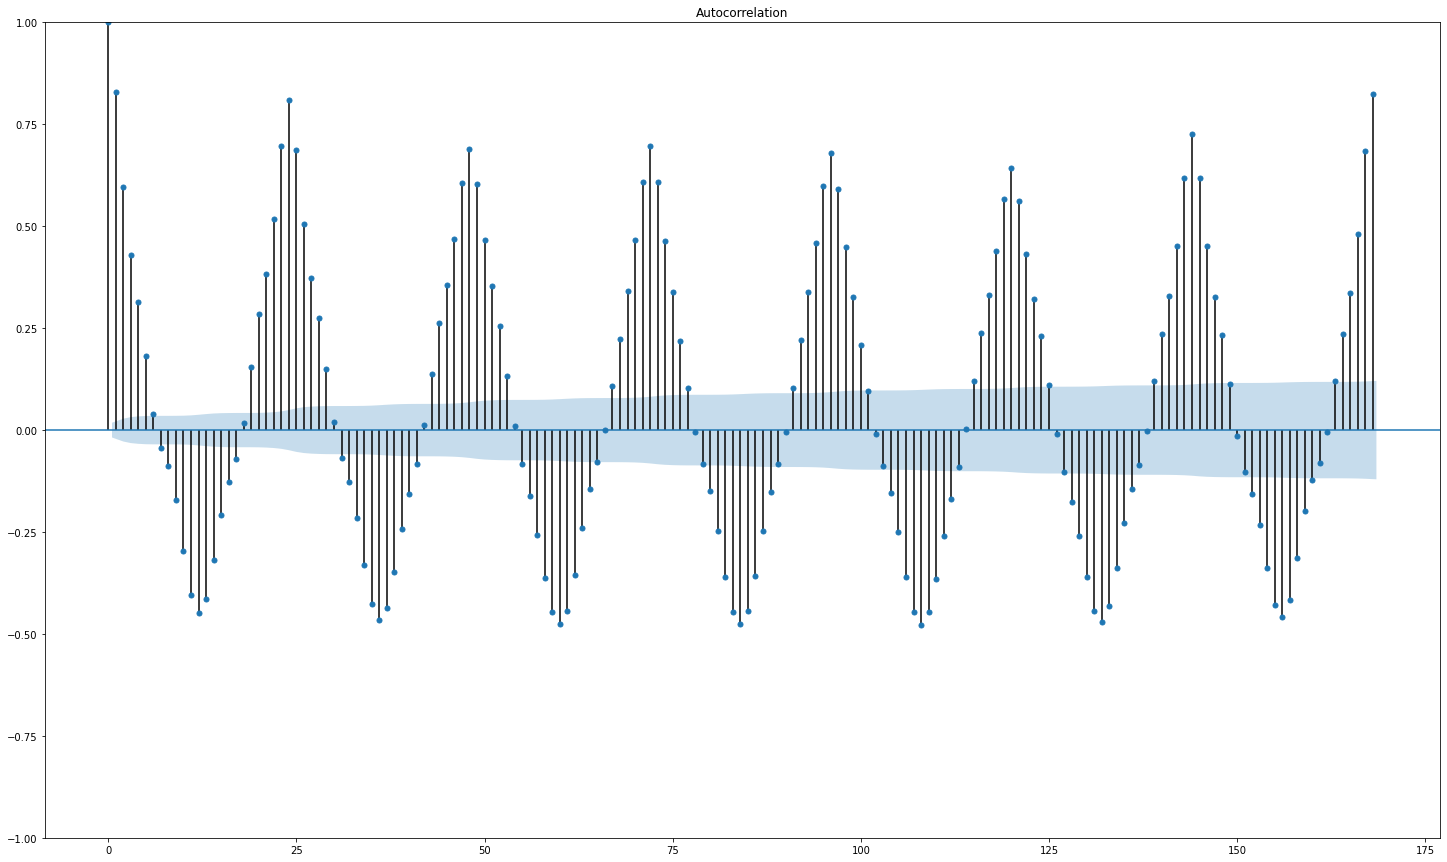

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(25,15))
plot_acf(df_train["count"], lags=7*24, ax=axs);

## forecast

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


ds
0     2019-08-01 00:00:00
1     2019-08-01 01:00:00
2     2019-08-01 02:00:00
3     2019-08-01 03:00:00
4     2019-08-01 04:00:00
...                   ...
13147 2021-01-29 20:00:00
13148 2021-01-29 21:00:00
13149 2021-01-29 22:00:00
13150 2021-01-29 23:00:00
13151 2021-01-30 00:00:00

[13152 rows x 1 columns]

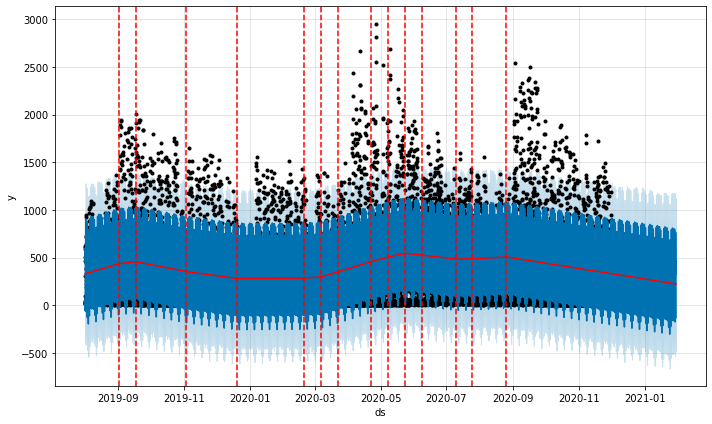

In [16]:
m = Prophet()
m.fit(
    df_train.rename(columns={"date": "ds", "count":"y"})
)

future = m.make_future_dataframe(periods=24*60, freq="H")
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
fig.show()

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
fig.show()

fig = plot_components_plotly(m, forecast)
fig.show()

future

## evaluate forecast

In [17]:
display(df_test.head(3))
display(forecast[["ds", "yhat"]].rename(columns={"ds": "date"}).tail(3))

df = pd.merge(
    df_test,
    forecast[["ds", "yhat"]].rename(columns={"ds": "date"}),
    left_on="date",
    right_on="date"
)
df['FC_E'] = df["yhat"] - df["count"]
df['FC_AE'] = np.abs(df['FC_E'])
df['FC_PE'] = df['FC_E'] / df["count"]
df['FC_APE'] = np.abs(df['FC_PE'])

display(df[["FC_E", "FC_AE", "FC_PE", "FC_APE"]].agg(['mean', 'median', 'std']).T)


date  count month_name day_name
11712 2020-12-01 01:00:00    5.0        Dec  Tuesday
11713 2020-12-01 02:00:00    4.0        Dec  Tuesday
11714 2020-12-01 03:00:00    7.0        Dec  Tuesday

date        yhat
13149 2021-01-29 22:00:00  -93.262506
13150 2021-01-29 23:00:00 -111.000938
13151 2021-01-30 00:00:00 -126.475636

mean      median         std
FC_E     20.470190   -6.393998  207.424280
FC_AE   158.741772  125.620402  135.009962
FC_PE         -inf   -0.024495         NaN
FC_APE         inf    0.800724         NaN

In [18]:
import plotly.figure_factory as ff
#nuttig ? weinig data om in dist te steken

df = df.dropna()
fig = ff.create_distplot(
    [df["FC_E"]],
    ["FC_E"],
    bin_size=0.05
)
fig.show()

fig = ff.create_distplot(
    [df["FC_AE"]],
    ["FC_AE"],
    bin_size=0.01
)
fig.show()

# auto arima

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [19]:
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

df = df_cycle[["date", "count"]].copy(deep=True)
df.set_index("date", inplace=True)
display(df)

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

count
date                      
2019-08-01 00:00:00   51.0
2019-08-01 01:00:00   25.0
2019-08-01 02:00:00   26.0
2019-08-01 03:00:00   19.0
2019-08-01 04:00:00   38.0
...                    ...
2021-11-01 23:00:00   14.0
2021-11-02 00:00:00    0.0
2021-11-02 01:00:00    0.0
2021-11-02 02:00:00    0.0
2021-11-02 03:00:00    0.0

[19778 rows x 1 columns]

(0.01, False)

In [20]:
df_train, df_test = split_train_test(df_cycle, date_column="date", hist_end=pd.Timestamp("2020-12"))

#print( len(df), len(df_train), len(df_test))
display( df_cycle.agg({"date": ["min", "max", "count"]}) )
display( df_train.agg({"date": ["min", "max", "count"]}) )
display( df_test.agg({"date": ["min", "max", "count"]}) )

date
min    2019-08-01 00:00:00
max    2021-11-02 03:00:00
count                19778

date
min    2019-08-01 00:00:00
max    2020-12-01 00:00:00
count                11712

date
min    2020-12-01 01:00:00
max    2021-11-02 03:00:00
count                 8066

In [ ]:
model = auto_arima(
    df_train["count"].to_numpy(),
    start_p=0,
    d=1,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=0,
    D=1,
    start_Q=5,
    max_P=5,
    max_D=5,
    max_Q=5,
    m=24, #day before
    seasonal=True,
    error_action="warn",
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    random_state=1801,
    n_fits=50
)

model.summary()

Performing stepwise search to minimize aic
